In [71]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano as thno
import theano.tensor as T
import warnings

from collections import OrderedDict
from scipy.optimize import fmin_powell
from scipy import integrate
from time import time
from sklearn.preprocessing import OneHotEncoder

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


In [89]:
def plot_traces(traces, retain=0):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:],
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

In [5]:
# datasets

raw_data = pd.read_csv("./dataset_spine.csv")
raw_data.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att,Unnamed: 13
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,NaN
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal,NaN
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal,Prediction is done by using binary classificat...
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal,NaN
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal,NaN


In [73]:
# datasets

spine_features = ['pelvic_incidence', 
                              'pelvic_tilt', 
                              'lumbar_lordosis_angle',
                              'sacral_slope', 
                              'pelvic_radius',
                              'degree_spondylolisthesis', 
                              'pelvic_slope',
                              'direct_tilt', 
                              'thoracic_slope', 
                              'cervical_tilt',
                              'sacrum_angle', 
                              'scoliosis_slope']

raw_data = pd.read_csv("./dataset_spine.csv",
                       header=None,
                       skiprows=[0],
                       names=spine_features +
                              ['back_status',
                              'notes'])

raw_data['binary_back_status'] = raw_data['back_status'].apply(lambda x: 1 if (x == 'Abnormal') else 0)
raw_data

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,back_status,notes,binary_back_status
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,NaN,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal,NaN,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal,Prediction is done by using binary classificat...,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal,NaN,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,0.129744,7.8433,14.7484,8.51707,-15.728927,11.5472,Normal,NaN,0
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,0.047913,19.1986,18.1972,7.08745,6.013843,43.8693,Normal,NaN,0
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,0.081070,16.2059,13.5565,8.89572,3.564463,18.4151,Normal,NaN,0
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,0.159251,14.7334,16.0928,9.75922,5.767308,33.7192,Normal,NaN,0


In [77]:
raw_data[raw_data.columns[:6]].describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


In [79]:
raw_data[raw_data.columns[6:]].describe()

,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,binary_back_status
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,0.472979,21.321526,13.064511,11.933317,-14.053139,25.645981,0.677419
std,0.285787,8.639423,3.399713,2.893265,12.225582,10.450558,0.468220
min,0.003220,7.027000,7.037800,7.030600,-35.287375,7.007900,0.000000
25%,0.224367,13.054400,10.417800,9.541140,-24.289522,17.189075,0.000000
50%,0.475989,21.907150,12.938450,11.953835,-14.622856,24.931950,1.000000
75%,0.704846,28.954075,15.889525,14.371810,-3.497094,33.979600,1.000000
max,0.998827,36.743900,19.324000,16.821080,6.972071,44.341200,1.000000


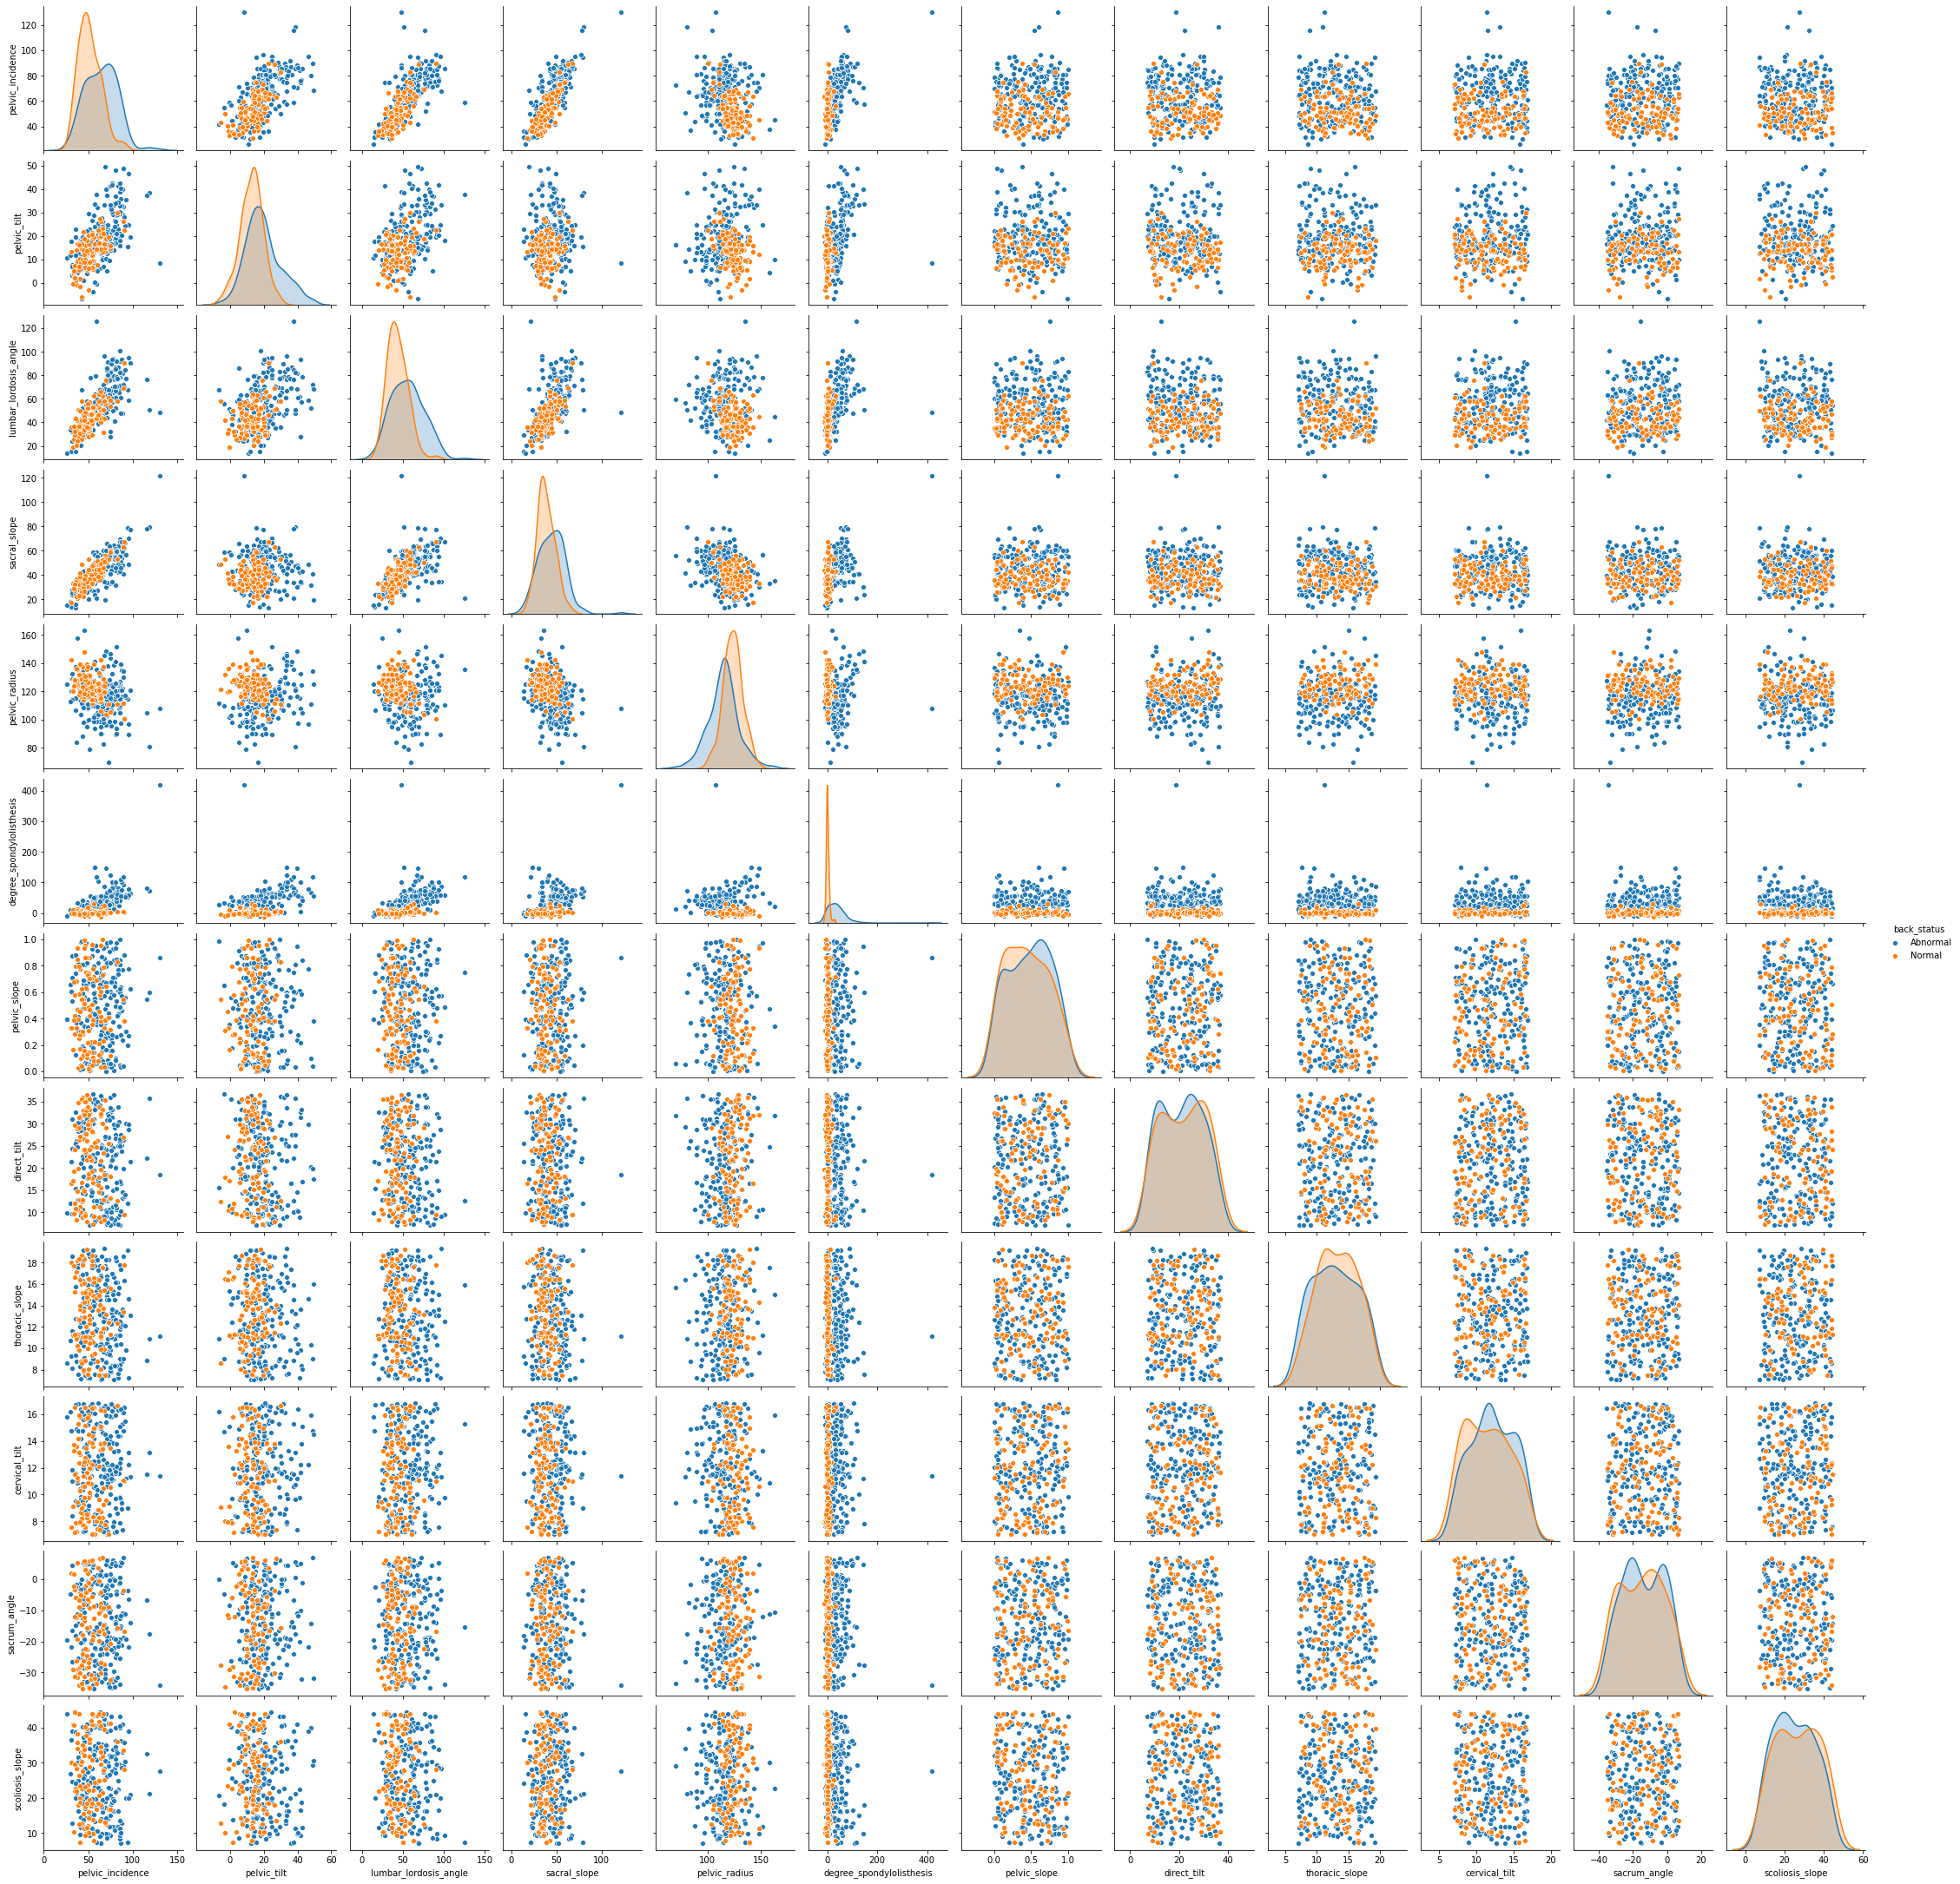

In [80]:
g = seaborn.pairplot(raw_data[spine_features + ['back_status']], hue="back_status")

From the above chart, there are a few key things we are looking for in our predictors:
* Features that have high collinearity. We want to remove predictors that essentially add no addititve explaining power to our model. We observe for instance that 
* Features that don't have notable differences in means and distribution structures between abnormal (blue) and normal (orange) data points. This means these features don't off

Variable selection is a very important process for any sort of regression modelling. We want to select features that maintain the common assumptions for most regression models which is:

* Little or no multicollinearity amongst the predictors
* Observations should be independent of one another
* 

From the covariance scatter matrix above, we look 

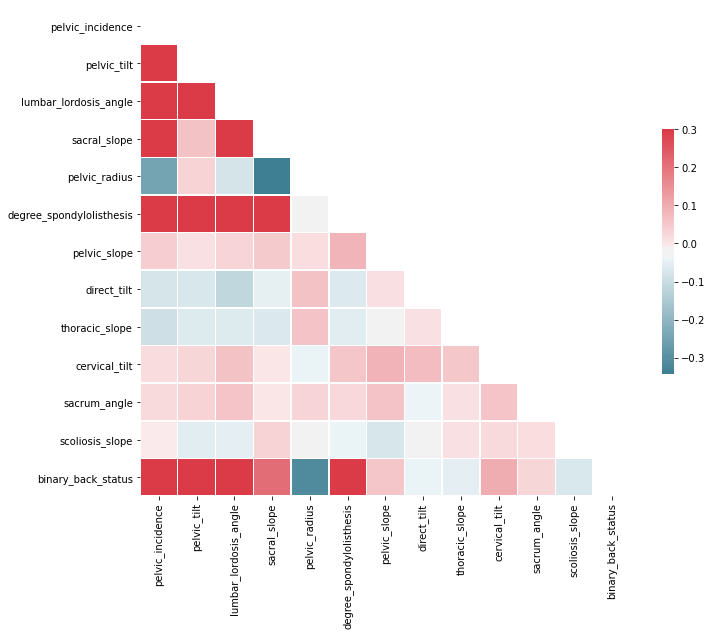

In [83]:
# Compute the correlation matrix
corr = raw_data[spine_features + ['binary_back_status']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(raw_data[spine_features], raw_data['binary_back_status'], test_size=0.20, random_state=1337)

In [95]:
train_df = pd.concat([X_train, y_train], axis=1)
print(train_df.shape)
train_df.head()

(248, 13)


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,binary_back_status
28,44.551012,21.931147,26.785916,22.619865,111.072920,2.652321,0.527891,32.4275,10.2244,11.71324,-28.506125,28.0470,1
261,74.976021,14.921705,53.730072,60.054317,105.645400,1.594748,0.318967,13.2564,11.3042,13.47166,-20.789258,41.2149,0
249,50.753290,20.235060,37.000000,30.518231,122.343516,2.288488,0.147745,28.9054,14.5673,11.98326,-26.881964,10.3342,0
56,43.349606,7.467469,28.065483,35.882137,112.776187,5.753277,0.592034,14.3377,14.2176,9.64034,-12.480751,13.0244,1
29,66.879211,24.891999,49.278597,41.987212,113.477018,-2.005892,0.677268,12.4271,8.2495,7.58784,-3.963385,27.3587,1


In [101]:
SELECTED_FEATURES = ['pelvic_tilt', 
                      'lumbar_lordosis_angle',
                      'pelvic_radius',
                      'degree_spondylolisthesis']

In [96]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('binary_back_status ~ pelvic_tilt + lumbar_lordosis_angle + pelvic_radius + degree_spondylolisthesis',
                            train_df[['binary_back_status'] + SELECTED_FEATURES],
                            family=pm.glm.families.Binomial())
    trace = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [degree_spondylolisthesis, pelvic_radius, lumbar_lordosis_angle, pelvic_tilt, Intercept]
Sampling 4 chains, 0 divergences: 100%|█| 8000/8000 [00:40<00:00, 195.27draws/s


In [97]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,9.963,2.738,4.244,14.682,0.070,0.051,1512.0,1451.0,1532.0,1739.0,1.0
pelvic_tilt,0.114,0.034,0.050,0.178,0.001,0.001,2137.0,2098.0,2139.0,2312.0,1.0
lumbar_lordosis_angle,-0.074,0.018,-0.109,-0.040,0.000,0.000,1699.0,1699.0,1693.0,2135.0,1.0
pelvic_radius,-0.079,0.020,-0.117,-0.038,0.001,0.000,1557.0,1511.0,1581.0,1878.0,1.0
degree_spondylolisthesis,0.168,0.026,0.118,0.217,0.001,0.000,1601.0,1601.0,1607.0,1955.0,1.0


F:\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
F:\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
F:\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
F:\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
F:\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


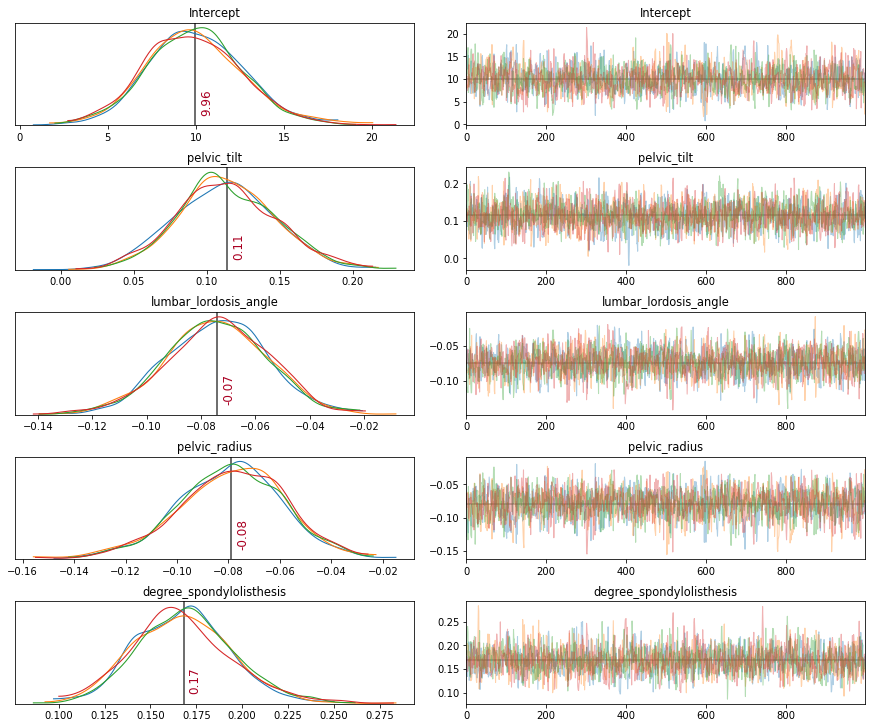

In [98]:
plot_traces(trace)

Some things we learned 

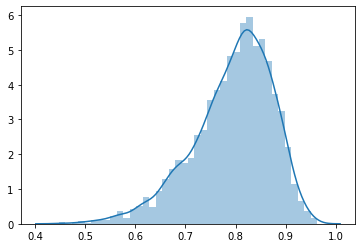

In [168]:
def lm_full(x):
    """ Calculate the logit(p) of a single data point as a posterior predictive distribution
    We take the mean to give us the best single point estimate
    """
    x = x.values
    pelvic_tilt, lumbar_lordosis_angle, pelvic_radius, degree_spondylolisthesis = x[0], x[1], x[2], x[3]
    shape = np.broadcast(pelvic_tilt, lumbar_lordosis_angle, pelvic_radius, degree_spondylolisthesis).shape
    x_norm = np.asarray([np.broadcast_to(x, shape)
                         for x in [pelvic_tilt, lumbar_lordosis_angle, pelvic_radius, degree_spondylolisthesis]])
    return 1 / (1 + np.exp(-(trace['Intercept'] +
                             trace['pelvic_tilt']*x_norm[0] +
                             trace['lumbar_lordosis_angle']*x_norm[1] +
                             trace['pelvic_radius']*x_norm[2] +
                             trace['degree_spondylolisthesis']*x_norm[3])))

# Predict probability of abnormality and normality from our bayesian model using trace coefficients
y_hat = X_test[SELECTED_FEATURES].apply(lm_full, axis=1)

# Posterior predictive of one test point
sns.distplot(y_hat.iloc[0])

In [169]:
""" Predict the probability of spine abnormality and calculate accuracy

Note: Since our prediction is on the interval of [0,1], we classify a
spine as abnormal if the prediction is above 50% and normal if below 50%.
"""

y_hat_mean = y_hat.apply(lambda x: 1 if x.mean() > 0.5 else 0)
prediction_results = np.unique((y_hat_mean == y_test), return_counts=True)
print(prediction_results)
print("# Correctly Classified: ", prediction_results[1][1])
print("# Incorrectly Classified: ", prediction_results[1][0])
print("% Model Accuracy: ", 100*round(prediction_results[1][1] / (prediction_results[1][1] + prediction_results[1][0]),4))

(array([False,  True]), array([ 9, 53], dtype=int64))
# Correctly Classified:  53
# Incorrectly Classified:  9
% Model Accuracy:  85.48
